In [2]:
import os, sys, numpy, pyRofex
from configparser import ConfigParser
from IPython.display import display
from matplotlib.pyplot import figure, subplots, style
from pandas import Series, DataFrame, Timestamp, Timedelta
from pandas import to_datetime, date_range, merge, concat
from pandas import Index, MultiIndex, DatetimeIndex
from mplfinance.plotting import plot
style.use("dark_background")

creds = ConfigParser()
creds.read("../auth/credentials.ini")
pyRofex.initialize(**creds["REMARKET"],
    environment = pyRofex.Environment.REMARKET)

Next: (1) Play models during live market. (2) Research, write & test \"Alma\" strategy. (3) Reformulate \"Interface._run_strategies\" to speed up loop. (4) Write \"main.py\". (5) Test live again and keep running during whole afternoon. (6) Write \"README.md\". (7) [optional] Move data templates to databases. (8) Deliver and exhibit

In [69]:
funcs = Series(pyRofex.__dir__())
funcs.loc[~ funcs.str.startswith("_") & funcs.str.islower()].to_list()

# get_market_data
# init_websocket_connection
# close_websocket_connection

# market_data_subscription
# add_websocket_market_data_handler
# remove_websocket_market_data_handler

# order_report_subscription
# add_websocket_order_report_handler
# remove_websocket_order_report_handler

# add_websocket_error_handler
# remove_websocket_error_handler

# send_order_via_websocket
# cancel_order_via_websocket

['clients',
 'components',
 'service',
 'initialize',
 'set_default_environment',
 'init_websocket_connection',
 'close_websocket_connection',
 'market_data_subscription',
 'order_report_subscription',
 'add_websocket_market_data_handler',
 'remove_websocket_market_data_handler',
 'add_websocket_order_report_handler',
 'remove_websocket_order_report_handler',
 'add_websocket_error_handler',
 'remove_websocket_error_handler',
 'set_websocket_exception_handler',
 'send_order_via_websocket',
 'cancel_order_via_websocket',
 'get_segments',
 'get_instruments',
 'get_all_instruments',
 'get_detailed_instruments',
 'get_instrument_details',
 'get_market_data',
 'get_trade_history',
 'send_order',
 'cancel_order',
 'get_order_status',
 'get_all_orders_status',
 'get_account_position',
 'get_detailed_position',
 'get_account_report']

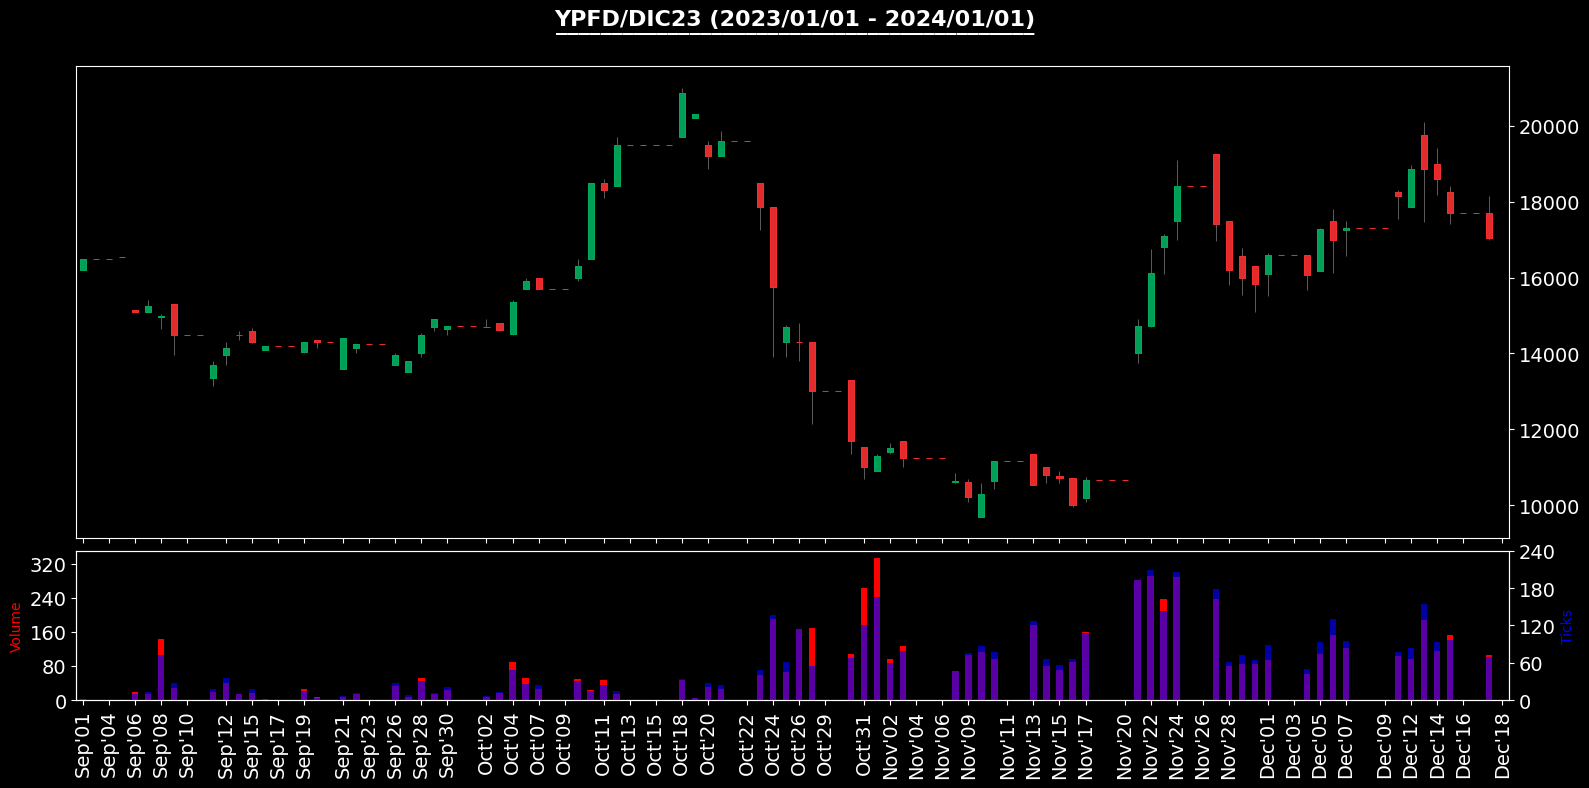

In [4]:
args = dict(
    ticker = "YPFD/DIC23",
    start_date = "2023-01-01",
    end_date = "2024-01-01",
)
hist = pyRofex.get_trade_history(**args)
hist = DataFrame(hist["trades"]).set_index("datetime")
hist.index = to_datetime(hist.index)
hist = hist[["symbol", "size", "price"]]
since, until = hist.index[[0, -1]]

ohlc = hist["price"].resample("D").ohlc()
volume = hist["size"].resample("D").sum()
ticks = hist["size"].resample("D").count()
ohlc["close"] = ohlc["close"].ffill()
ohlc = ohlc.bfill(axis = "columns")

fig = figure(figsize = (16, 8))
axp = fig.add_subplot(4, 1, (1, 3))
axs = fig.add_subplot(4, 1, (4, 4), sharex = axp)
axt = axs.twinx()
axp.tick_params(labelsize = 14)
axs.tick_params(labelsize = 14), axs.set_ylabel("Volume", color = "red")
axt.tick_params(labelsize = 14), axt.set_ylabel("Ticks", color = "blue")
plot(ax = axp, data = ohlc, type = "candle", style = "yahoo")
volume.plot.bar(ax = axs, color = "red", alpha = 1.00)
ticks.plot.bar(ax = axt, color = "blue", alpha = 0.65)

xticks = numpy.linspace(0, len(ohlc), 50).astype(int)
xlabels = date_range(since, until, periods = len(xticks)).strftime("%b'%d")
axs.set_xticks(xticks), axs.set_xticklabels(xlabels, rotation = 90)
axs.set_xlim(- 0.5, len(ohlc) + 0.5)
axs.set_xlabel(""); axp.set_ylabel("")

vmax = volume.max()
vmult = 10.0 ** int(numpy.log10(vmax))
vmax = (int(vmax / vmult) + 1) * vmult
vticks = numpy.arange(0, vmax, vmax // 5)
axs.set_yticks(vticks)
tmax = ticks.max()
tmult = 10.0 ** int(numpy.log10(tmax))
tmax = (int(tmax / tmult) + 1) * tmult
tticks = numpy.arange(0, tmax, tmax // 5)
axt.set_yticks(tticks)

args["end_date"] = args["end_date"].replace("-", "/")
args["start_date"] = args["start_date"].replace("-", "/")
title = "{ticker} ({start_date} - {end_date})".format(**args)
args["end_date"] = args["end_date"].replace("/", "")
args["start_date"] = args["start_date"].replace("/", "")
filename = "{ticker}_{start_date}_{end_date}.jpg".format(**args)
title = title + "\n" + "‾" * int(len(title) * 1.2)
filename = filename.replace(" ", "").replace("/", "-")
fig.suptitle(title, fontsize = 16, fontweight = "bold")
fig.set_tight_layout({"h_pad": 0.01, "w_pad": 0.05})
fig.savefig(filename, dpi = 200)

In [4]:
from pandas import Timestamp
- (Timestamp.utcnow() - Timestamp("2024/01/31 00:00:00", tz = "UTC")).total_seconds() / 86400

38.25819326199074

<h3><u><b>
Con respecto a la estrategia provista
</b></u></h3>

La explicación completa a nivel matemático y procedimental, está en el archivo "<code>docs/rate_arb.md</code>". En principio, la lógica de la función "<code>Alma.on_tick</code>" fue formulada para arrojar señales para todos los ticks entrantes, sin ningun tipo de bloqueo. La idea no es simular la estrategia de trading en su operatoria común y corriente, sino proveer de información sobre las potenciales señales ("<code>Signal</code>") por oportunidades de arbitraje.

En principio: cada instancia del objeto "<code>Signal</code>" tiene asociado un atributo "<code>comment</code>" para que uno pueda proveer algún tipo de descripción sobre su origen o motivo (ej: si es producida por un cruce de médias móviles, se querría saber el valor de dichos indicadores). En el caso de la estrategia "<code>Alma</code>", el "<code>comment</code>" tendrá el siguiente formato:
```json
    da: 106.0, db: 104.0, ua: 100.00, rp: 0.0011, rt: -0.0015, exp: 38.25
```
Donde:
<ul><li>"<code>da</code>" significa "<b>derivative ask</b>": Precio ask del futuro (derivado).
</li><li>"<code>db</code>" significa "<b>derivative bid</b>": Precio bid del futuro (derivado).
</li><li>"<code>ua</code>" significa "<b>underlying ask</b>": Precio ask del subyacente (spot).
</li><li>"<code>rp</code>" significa "<b>rate payer</b>": Tasa de interés "payer" (colocadora).
</li><li>"<code>rt</code>" significa "<b>rate taker</b>": Tasa de interés "taker" (tomadora).
</li><li>"<code>exp</code>" significa "<b>expiration</b>": Días restantes para el vencimiento del futuro.
</li></ul>

La instancia de "<code>Signal</code>" posee varios parámetros adicionales, descriptos en detalle dentro del docstring de "<code>Signal</code>" (parte superior del script "<code>models/strategy.py</code>"). A fines prácticos, interesan 3 de ellos:
<ul><li>"<code>side</code>": Compra (BUY) o venta (SELL). 
</li><li>"<code>price</code>": Precio de ejecución (inmediata) de la órden. Si es una compra, es el precio "ask". Si es una venta, es el "bid".
</li><li>"<code>TP</code>": Precio de cierre de la posición implicada; básicamente igual al precio proyectado al cabo de un día, teniendo en cuenta a la tasa de interés calculada:
<ul><li>Si es una compra (BUY), "TP" es el precio "<b>bid</b>" aumentado por "<b>1 + tasa de interés taker</b>".
</li><li>Si es una venta (SELL), "TP" es el precio "<b>ask</b>" disminuido por "<b>1 - tasa de interés taker</b>".
</li></ul>
</li></ul>

Como todas las operaciones son de tamaño "<code>size = 1</code>" por ahora, La ganancia o pérdida proyectada sería la diferencia entre el "TP" y el "price":
<ul><li>Si es una compra (BUY), "<code>profit = TP - price</code>".
</li><li>Si es una venta (SELL), "<code>profit = price - TP</code>".
</li></ul>

En resumen, para interpretar el origen y resultado proyectado de una órden:
<ul></li>Leer el comentario "comment" y sus 6 valores, especialmente las tasas ("rp" y "rt").
</li><li>Leer el valor de "side" para reconocer cual tasa se tomó para ejecutar la órden.
</li><li>Leer los valores de "price" y "TP". El valor absoluto de la diferencia es el profit esperado.
</li></ul>


<h3><u><b>
Tareas pendientes
</b></u></h3>

Como proyecto de prueba, quedan varias cosas a desarrollar a futuro. Algunas de ellas:
<ul><li>Reparar cierre manual por "<font color = "red"><b>keyboard interrupt</b></font>", el cual no termina de finalizar el proceso. Puede deberse a que dentro del nivel superficial de la biblioteca "<code>pyRofex</code>" no se tiene control sobre el "cliente" del WebSocket. Teóricamente está presente en "<code>pyRofex.components.environment</code>", pero falta tiempo de investigación. Entonces no puede manipularse la conexión y los feeds de manera directa (por ejemplo: para agregar "listeners" de <code>KeyboardInterrupt</code> a los callbacks, o para tener mayor control sobre el thread que contiene el proceso del WebSocket). Por ahora, si bien el sistema no opera luego del <code>KeyboardInterrupt</code>, al proceso se lo finaliza cerrando la consola del bash (lo cual es áltamente sub-optimo).
</li><li>Completar función "<code>Interface.on_update_orders</code>" y "<code>Strategy.on_order</code>". Hasta ahora solo se trabajó con órdenes de ejecución inmediata (a mejores bid/ask); "<code>pyRofex.OrderType.MARKET</code>". Con lo cual no se vió la necesidad de modificar o cancelar órdenes, como tampoco se vieron datos de WebSocket sobre órdenes pendientes siendo actualizadas/ejecutadas.
</li><li>Mejorar error handling para casos particulares como datos tick anómalos (ej: sin bids/asks, instrumentos vencidos, etc.) u órdenes mal formuladas (ej: "sizes" menores al mínimo permisible dado por las especificaciones del instrumento).
</li><li>Mejorar estructuras de iteración sobre estrategias. Hasta ahora, la función "<code>Interface._run_strategies</code>" recorre una por una estrategia, aplicandole los datos de mercado mas recientes; lo cual puede tener ineficiencias. Por ejemplo: si 2 estrategias operan el mismo instrumento, la búsqueda y copia de ticks históricos para ese instrumento se hace 2 veces, cuando en realidad podría hacerse una.
</li><li>Probar con otros portales de acceso diferentes a ReMarkets, como Live (Rofex).
</li><li>Crear algúna funcionalidad que accione órdenes basadas en SLs y TPs dentro de "<code>Interface</code>". Como la API de "<code>pyRofex</code>" no tiene tales parámetros en su endpoint para envío de órdenes, se podría crear algo que establezca las órdenes necesarias para producir el mismo efecto (ej.: inmediatamente luego de un "buy market", ubicar un "sell limit" por encima, a precio "TP".)
</li><li>Agregar funcionalidades de "sizing" a la estrategia "<code>Alma</code>": En lugar de todas órdenes de tamaño 1, agregar algún tipo de cálculo basado en máximo riesgo permisible por posición.